#### DNN

### imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import datasets
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Input, Dense

2022-12-11 03:04:44.143876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 03:04:44.354340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 03:04:44.354380: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-11 03:04:45.242494: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
train_csv_file = pd.read_csv("train.csv")



In [3]:
def encode(train_csv_file):
    
    #encoding species strings
    labels = LabelEncoder().fit(train_csv_file.species)
    classes = list(labels.classes_)
    labels = labels.transform(train_csv_file.species)
    
    train_df = train_csv_file.drop(["species", "id"],axis = 1)
    
    return train_df, labels, classes



In [4]:
train_df, labels, classes = encode(train_csv_file)
train_df.head()


,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [5]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x


train_df = remove_collinear_features(train_df,0.99)

Removed Columns {'shape14', 'shape53', 'shape45', 'shape22', 'shape46', 'shape43', 'shape13', 'shape49', 'shape18', 'shape54', 'shape51', 'shape12', 'shape23', 'shape19', 'shape44', 'shape50', 'shape10', 'shape15', 'shape48', 'shape17', 'shape47', 'shape16', 'shape21', 'shape11', 'shape20', 'shape52'}


In [6]:
scaled_data = StandardScaler().fit_transform(train_df)

In [7]:
# X = train_df.values
X = scaled_data
y = tfk.utils.to_categorical(labels)

In [8]:
#Shuffle split
sss = StratifiedShuffleSplit(n_splits = 1,test_size = .3,random_state = 30)
sss.get_n_splits(X,y)

1

In [9]:
for train_index, val_index in sss.split(X,y):
    X_train, X_val = X[train_index],X[val_index]
    y_train, y_val = y[train_index],y[val_index]

In [10]:
X_train.shape

(693, 166)

In [11]:
X_val.shape

(297, 166)

In [12]:
y_train.shape

(693, 99)

In [13]:
y_val.shape

(297, 99)

In [14]:
def model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Dense(150, activation='tanh',kernel_initializer=tfk.initializers.HeNormal()))
    model.add(Dropout(.25))
    model.add(Dense(99, activation='softmax',kernel_initializer=tfk.initializers.HeNormal()))
    
    return model

In [15]:
nn_model = model(X_train.shape[1:])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               25050     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 99)                14949     
                                                                 
Total params: 39,999
Trainable params: 39,999
Non-trainable params: 0
_________________________________________________________________


2022-12-11 03:04:47.888622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 03:04:47.889229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-11 03:04:47.889350: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-11 03:04:47.889463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-11 03:04:47.889549: W tensorflow/c

In [16]:
nn_model.compile(optimizer=tfk.optimizers.RMSprop(learning_rate = 0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
X_train.shape

(693, 166)

In [18]:
history = nn_model.fit(X_train,y_train, batch_size=32,validation_split=.2, epochs=1000)

Epoch 1/1000
18/18 [==============================] - 1s 16ms/step - loss: 4.5094 - accuracy: 0.0686 - val_loss: 3.5968 - val_accuracy: 0.2302
Epoch 2/1000
18/18 [==============================] - 0s 5ms/step - loss: 3.2942 - accuracy: 0.2653 - val_loss: 2.9489 - val_accuracy: 0.3453
Epoch 3/1000
18/18 [==============================] - 0s 6ms/step - loss: 2.5176 - accuracy: 0.5036 - val_loss: 2.4380 - val_accuracy: 0.5540
Epoch 4/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.9808 - accuracy: 0.6606 - val_loss: 2.0152 - val_accuracy: 0.6691
Epoch 5/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5169 - accuracy: 0.7996 - val_loss: 1.6826 - val_accuracy: 0.7626
Epoch 6/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.1875 - accuracy: 0.8755 - val_loss: 1.3837 - val_accuracy: 0.7842
Epoch 7/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.9292 - accuracy: 0.9061 - val_loss: 1.1691 - val_accuracy: 0.8489
Epoch

18/18 [==============================] - 0s 4ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0669 - val_accuracy: 0.9928
Epoch 59/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0673 - val_accuracy: 0.9928
Epoch 60/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0664 - val_accuracy: 0.9928
Epoch 61/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.9928
Epoch 62/1000
18/18 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0661 - val_accuracy: 0.9928
Epoch 63/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9928
Epoch 64/1000
18/18 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0651 - val_accuracy: 0.9928
Epoch 65/1000

18/18 [==============================] - 0s 4ms/step - loss: 5.6654e-04 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9928
Epoch 115/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.9573e-04 - accuracy: 1.0000 - val_loss: 0.0545 - val_accuracy: 0.9928
Epoch 116/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.3717e-04 - accuracy: 1.0000 - val_loss: 0.0532 - val_accuracy: 0.9928
Epoch 117/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.8800e-04 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9928
Epoch 118/1000
18/18 [==============================] - 0s 4ms/step - loss: 4.9781e-04 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9928
Epoch 119/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.1327e-04 - accuracy: 1.0000 - val_loss: 0.0522 - val_accuracy: 0.9928
Epoch 120/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.0430e-04 - accuracy: 1.0000 - val_loss: 0.0513 - 

18/18 [==============================] - 0s 4ms/step - loss: 3.4993e-04 - accuracy: 1.0000 - val_loss: 0.0446 - val_accuracy: 0.9928
Epoch 170/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.2723e-04 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9928
Epoch 171/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.3062e-04 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9928
Epoch 172/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.1462e-04 - accuracy: 1.0000 - val_loss: 0.0445 - val_accuracy: 0.9928
Epoch 173/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.7809e-04 - accuracy: 1.0000 - val_loss: 0.0444 - val_accuracy: 0.9928
Epoch 174/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.2788e-04 - accuracy: 1.0000 - val_loss: 0.0443 - val_accuracy: 0.9928
Epoch 175/1000
18/18 [==============================] - 0s 4ms/step - loss: 3.5400e-04 - accuracy: 1.0000 - val_loss: 0.0438 - 

18/18 [==============================] - 0s 4ms/step - loss: 2.6098e-04 - accuracy: 1.0000 - val_loss: 0.0414 - val_accuracy: 0.9928
Epoch 225/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.2878e-04 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9928
Epoch 226/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.9255e-04 - accuracy: 1.0000 - val_loss: 0.0407 - val_accuracy: 0.9928
Epoch 227/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.4583e-04 - accuracy: 1.0000 - val_loss: 0.0408 - val_accuracy: 0.9928
Epoch 228/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.4192e-04 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9928
Epoch 229/1000
18/18 [==============================] - 0s 4ms/step - loss: 2.5995e-04 - accuracy: 1.0000 - val_loss: 0.0406 - val_accuracy: 0.9928
Epoch 230/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.9081e-04 - accuracy: 1.0000 - val_loss: 0.0405 - 

18/18 [==============================] - 0s 4ms/step - loss: 1.9782e-04 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9928
Epoch 280/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5787e-04 - accuracy: 1.0000 - val_loss: 0.0390 - val_accuracy: 0.9928
Epoch 281/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.8166e-04 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 0.9928
Epoch 282/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.7896e-04 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 0.9928
Epoch 283/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.8254e-04 - accuracy: 1.0000 - val_loss: 0.0387 - val_accuracy: 0.9928
Epoch 284/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.9461e-04 - accuracy: 1.0000 - val_loss: 0.0389 - val_accuracy: 0.9928
Epoch 285/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.8605e-04 - accuracy: 1.0000 - val_loss: 0.0389 - 

18/18 [==============================] - 0s 4ms/step - loss: 1.5526e-04 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 0.9928
Epoch 335/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.3989e-04 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 0.9928
Epoch 336/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5103e-04 - accuracy: 1.0000 - val_loss: 0.0375 - val_accuracy: 0.9928
Epoch 337/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.8234e-04 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 0.9928
Epoch 338/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5428e-04 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9928
Epoch 339/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.5533e-04 - accuracy: 1.0000 - val_loss: 0.0379 - val_accuracy: 0.9928
Epoch 340/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.4534e-04 - accuracy: 1.0000 - val_loss: 0.0379 - 

18/18 [==============================] - 0s 4ms/step - loss: 1.2609e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9928
Epoch 390/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3609e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9928
Epoch 391/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3814e-04 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9928
Epoch 392/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3060e-04 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 0.9928
Epoch 393/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.2408e-04 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9928
Epoch 394/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3831e-04 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9928
Epoch 395/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.4573e-04 - accuracy: 1.0000 - val_loss: 0.0365 - 

18/18 [==============================] - 0s 4ms/step - loss: 1.2636e-04 - accuracy: 1.0000 - val_loss: 0.0352 - val_accuracy: 0.9928
Epoch 445/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.2035e-04 - accuracy: 1.0000 - val_loss: 0.0352 - val_accuracy: 0.9928
Epoch 446/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.1703e-04 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9928
Epoch 447/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.1434e-04 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9928
Epoch 448/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.1961e-04 - accuracy: 1.0000 - val_loss: 0.0353 - val_accuracy: 0.9928
Epoch 449/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.3607e-04 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 0.9928
Epoch 450/1000
18/18 [==============================] - 0s 4ms/step - loss: 1.1481e-04 - accuracy: 1.0000 - val_loss: 0.0354 - 

18/18 [==============================] - 0s 4ms/step - loss: 9.2185e-05 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 0.9928
Epoch 500/1000
18/18 [==============================] - 0s 5ms/step - loss: 9.9367e-05 - accuracy: 1.0000 - val_loss: 0.0347 - val_accuracy: 0.9928
Epoch 501/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.4341e-05 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9928
Epoch 502/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.6815e-05 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9928
Epoch 503/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.8373e-05 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9928
Epoch 504/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.8157e-05 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 0.9928
Epoch 505/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.0137e-04 - accuracy: 1.0000 - val_loss: 0.0346 - 

18/18 [==============================] - 0s 4ms/step - loss: 9.5748e-05 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.9928
Epoch 555/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.4329e-05 - accuracy: 1.0000 - val_loss: 0.0342 - val_accuracy: 0.9928
Epoch 556/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.9619e-05 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9928
Epoch 557/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.4018e-05 - accuracy: 1.0000 - val_loss: 0.0340 - val_accuracy: 0.9928
Epoch 558/1000
18/18 [==============================] - 0s 4ms/step - loss: 9.0197e-05 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9928
Epoch 559/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.1691e-05 - accuracy: 1.0000 - val_loss: 0.0341 - val_accuracy: 0.9928
Epoch 560/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.2404e-05 - accuracy: 1.0000 - val_loss: 0.0341 - 

18/18 [==============================] - 0s 5ms/step - loss: 8.3248e-05 - accuracy: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9928
Epoch 610/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.0427e-04 - accuracy: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9928
Epoch 611/1000
18/18 [==============================] - 0s 5ms/step - loss: 7.5807e-05 - accuracy: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9928
Epoch 612/1000
18/18 [==============================] - 0s 5ms/step - loss: 1.0828e-04 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9928
Epoch 613/1000
18/18 [==============================] - 0s 5ms/step - loss: 7.8665e-05 - accuracy: 1.0000 - val_loss: 0.0339 - val_accuracy: 0.9928
Epoch 614/1000
18/18 [==============================] - 0s 5ms/step - loss: 9.1046e-05 - accuracy: 1.0000 - val_loss: 0.0338 - val_accuracy: 0.9928
Epoch 615/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.9506e-05 - accuracy: 1.0000 - val_loss: 0.0338 - 

18/18 [==============================] - 0s 4ms/step - loss: 6.8949e-05 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9928
Epoch 665/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.1962e-05 - accuracy: 1.0000 - val_loss: 0.0335 - val_accuracy: 0.9928
Epoch 666/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.2788e-05 - accuracy: 1.0000 - val_loss: 0.0335 - val_accuracy: 0.9928
Epoch 667/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.0065e-05 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9928
Epoch 668/1000
18/18 [==============================] - 0s 4ms/step - loss: 8.1679e-05 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9928
Epoch 669/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.3818e-05 - accuracy: 1.0000 - val_loss: 0.0337 - val_accuracy: 0.9928
Epoch 670/1000
18/18 [==============================] - 0s 4ms/step - loss: 7.1302e-05 - accuracy: 1.0000 - val_loss: 0.0337 - 

18/18 [==============================] - 0s 4ms/step - loss: 7.0250e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9928
Epoch 720/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.2500e-05 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 0.9928
Epoch 721/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.9991e-05 - accuracy: 1.0000 - val_loss: 0.0322 - val_accuracy: 0.9928
Epoch 722/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.6870e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9928
Epoch 723/1000
18/18 [==============================] - 0s 4ms/step - loss: 7.3731e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9928
Epoch 724/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.5645e-05 - accuracy: 1.0000 - val_loss: 0.0324 - val_accuracy: 0.9928
Epoch 725/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.8126e-05 - accuracy: 1.0000 - val_loss: 0.0324 - 

18/18 [==============================] - 0s 4ms/step - loss: 6.6736e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 775/1000
18/18 [==============================] - 0s 4ms/step - loss: 7.3938e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 776/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.8594e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 777/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.9950e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 778/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.5280e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 779/1000
18/18 [==============================] - 0s 4ms/step - loss: 7.0120e-05 - accuracy: 1.0000 - val_loss: 0.0314 - val_accuracy: 1.0000
Epoch 780/1000
18/18 [==============================] - 0s 4ms/step - loss: 7.1171e-05 - accuracy: 1.0000 - val_loss: 0.0315 - 

18/18 [==============================] - 0s 3ms/step - loss: 6.5542e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 830/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.0644e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 831/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.9181e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 832/1000
18/18 [==============================] - 0s 4ms/step - loss: 7.0553e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 833/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.6426e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 834/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.5636e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 1.0000
Epoch 835/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.4796e-05 - accuracy: 1.0000 - val_loss: 0.0311 - 

18/18 [==============================] - 0s 4ms/step - loss: 5.7106e-05 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 885/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.5451e-05 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 886/1000
18/18 [==============================] - 0s 3ms/step - loss: 6.3095e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 887/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.7995e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 888/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.3647e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 889/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.7919e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 890/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.2965e-05 - accuracy: 1.0000 - val_loss: 0.0304 - 

18/18 [==============================] - 0s 3ms/step - loss: 5.4519e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 940/1000
18/18 [==============================] - 0s 4ms/step - loss: 6.3983e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 941/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.5467e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 942/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.3957e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 943/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.1619e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 944/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.5320e-05 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 945/1000
18/18 [==============================] - 0s 4ms/step - loss: 4.9960e-05 - accuracy: 1.0000 - val_loss: 0.0302 - 

18/18 [==============================] - 0s 4ms/step - loss: 5.3335e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 995/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.0969e-05 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 1.0000
Epoch 996/1000
18/18 [==============================] - 0s 4ms/step - loss: 4.8199e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 997/1000
18/18 [==============================] - 0s 4ms/step - loss: 4.5663e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 998/1000
18/18 [==============================] - 0s 3ms/step - loss: 5.7103e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 999/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.3749e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 1.0000
Epoch 1000/1000
18/18 [==============================] - 0s 4ms/step - loss: 5.2021e-05 - accuracy: 1.0000 - val_loss: 0.0299 -

/tmp/ipykernel_293124/974158325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_293124/974158325.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

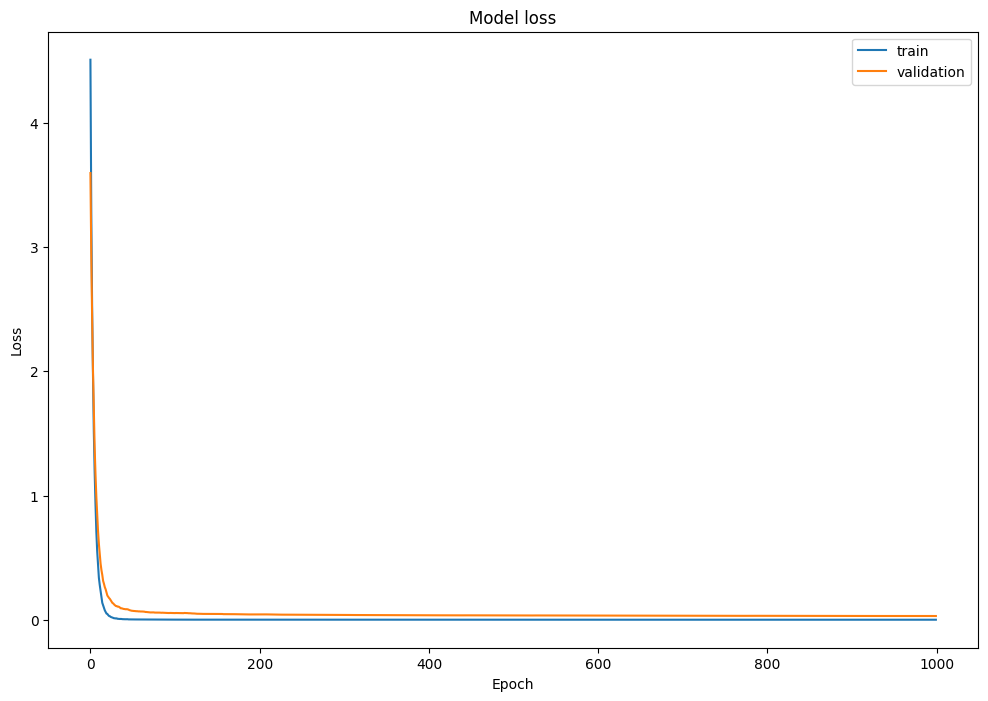

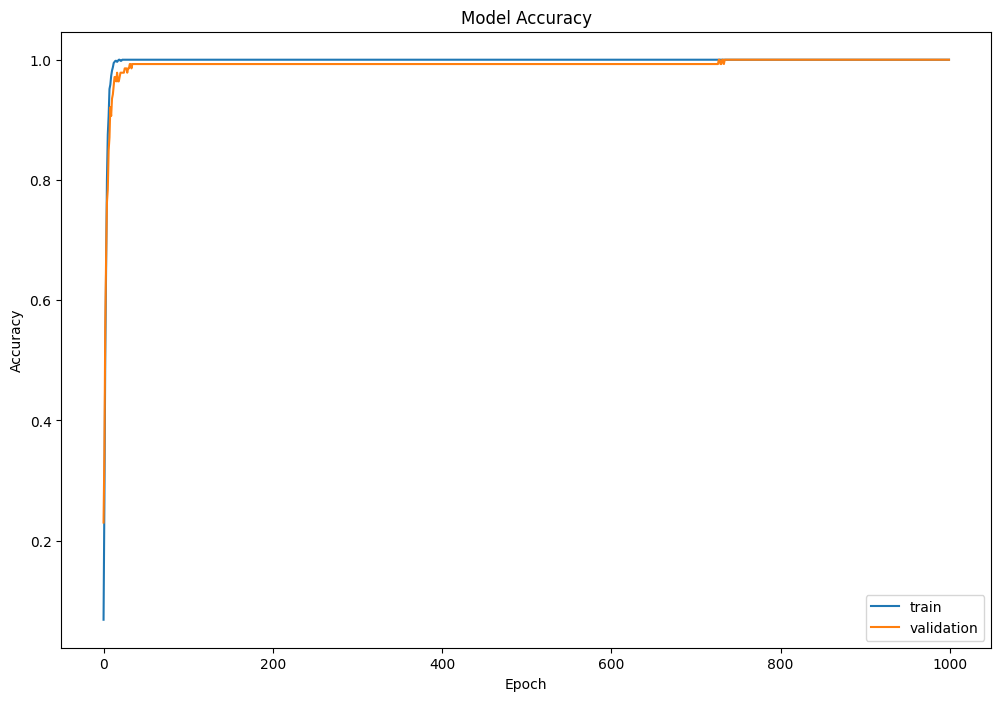

In [19]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [20]:
y_preds = nn_model.predict(X_val)
y_preds_classes = np.argmax(y_preds,axis=1)

10/10 [==============================] - 0s 1ms/step


In [21]:
y_preds_classes

array([12, 15, 56, 34, 82, 54, 36, 59, 15,  6, 14, 83, 21,  2, 84, 27, 47,
       51, 83, 88,  2, 19, 18, 78, 94,  7, 83, 24, 14, 20, 84,  4, 53, 54,
        7, 12, 20, 28, 23, 70, 94, 92, 24, 93, 16, 29,  3, 80, 98, 38, 30,
       17, 32, 74, 88, 27, 24,  3, 23, 98, 23, 18, 55, 48, 41, 92, 37, 43,
       68, 55,  9, 79, 54, 50, 90, 80,  1, 77, 11, 49, 59,  4, 21, 53,  1,
       68, 85, 40, 57, 41, 43, 82, 82,  5, 66, 39, 38, 13, 44, 16, 66,  9,
       52, 45, 13, 13, 51, 65, 73, 97, 40, 10, 35, 84, 32, 42, 45,  8, 87,
       57, 10, 49, 56, 37, 64, 70, 85, 31, 75, 86, 89, 27,  5, 34, 48, 98,
        4, 11, 77, 62, 42, 19, 34, 74, 79, 86,  0, 40, 30, 91, 88, 97, 39,
       81, 17, 38, 52, 18,  6, 80, 93, 44, 89, 95, 33, 80, 82, 44, 75, 73,
       50, 42, 66, 58,  5, 78, 92,  8, 81, 89, 26, 51,  8, 90,  1, 36, 96,
       20, 46, 67, 29, 32, 76, 56, 76, 76, 61, 19, 60, 49, 33, 25, 60, 69,
       60,  9, 28, 72, 26, 35, 77, 35, 22, 58, 91, 11, 52, 30, 86, 58, 64,
       15, 46, 91, 70, 75

In [22]:
y_val = np.argmax(y_val, axis=1)

In [23]:
y_val == y_preds_classes

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [24]:
y_test = tfk.utils.to_categorical(y_val)
loss , accuracy = nn_model.evaluate(X_val, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9731


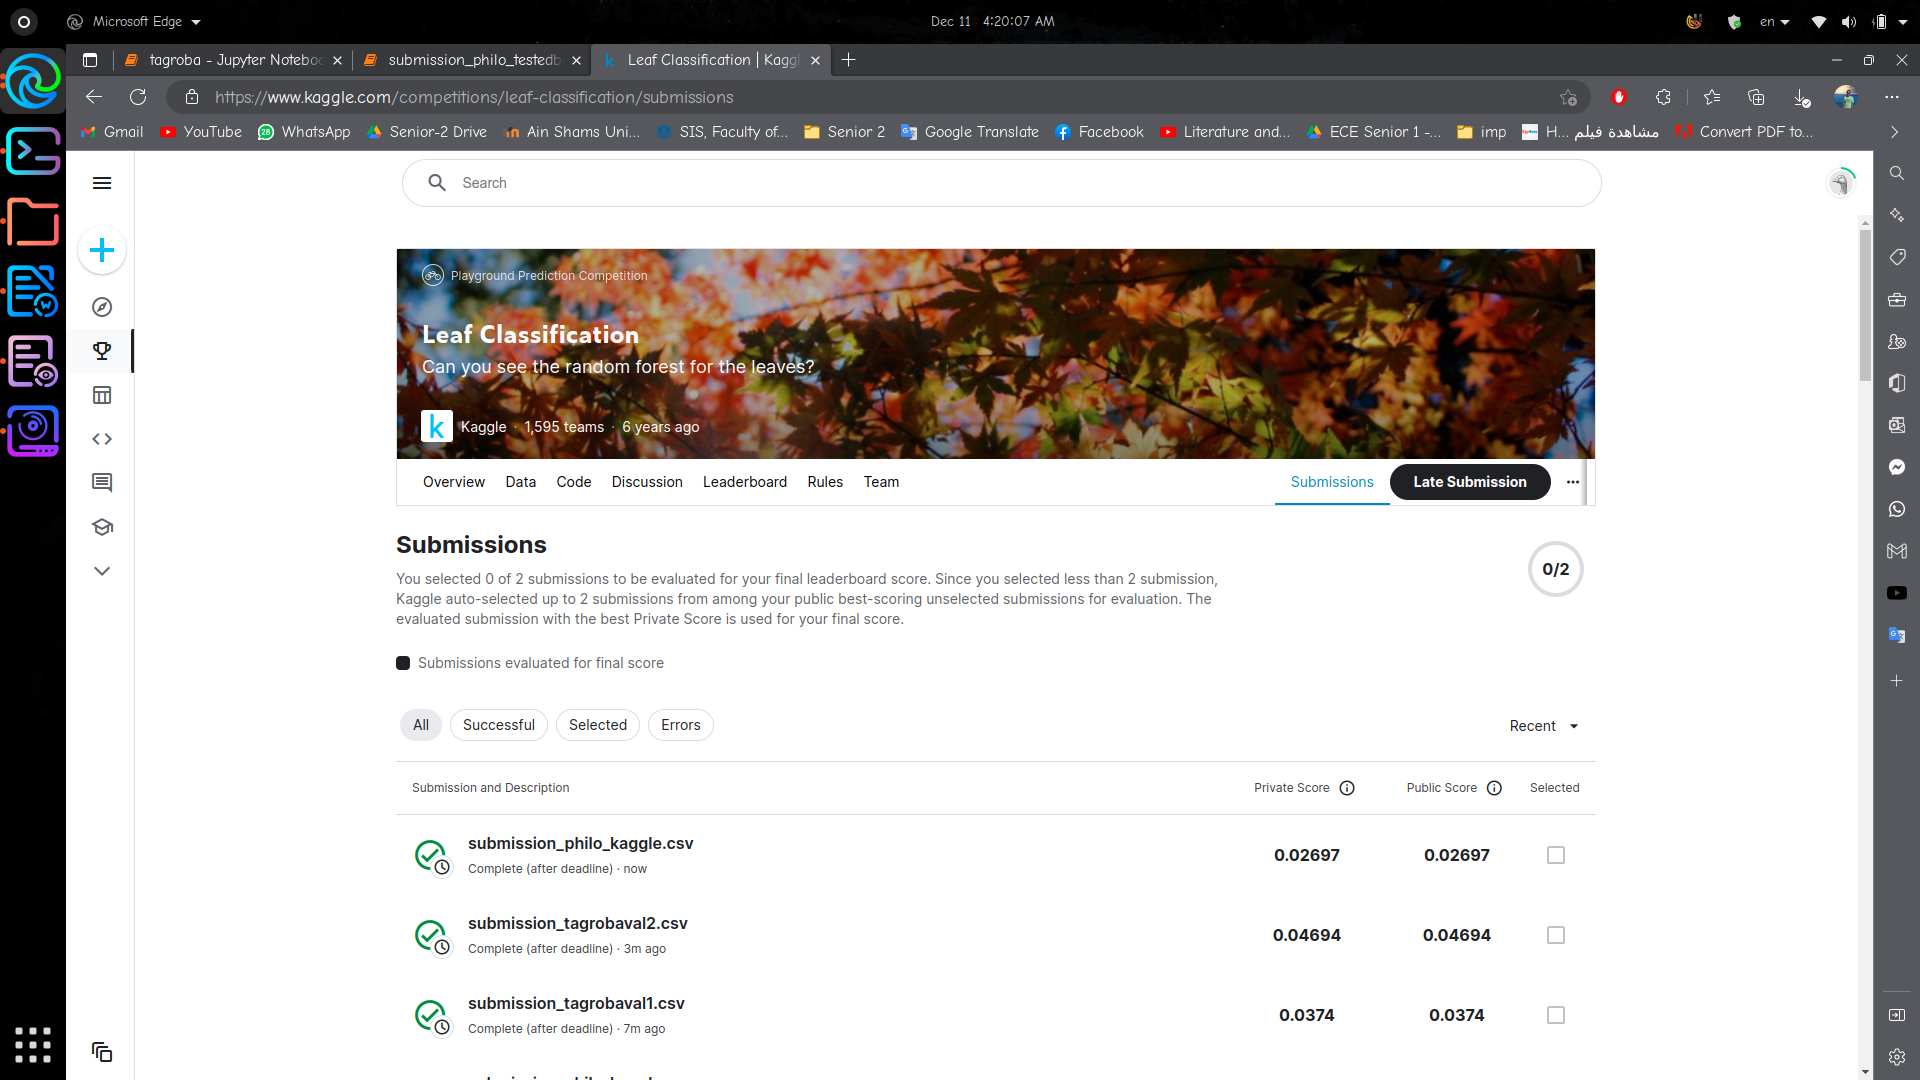